In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_emotion.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [7]:
df = df.dropna(subset='탈모 효과 및 쿨링감', axis=0).reset_index(drop=True)

In [8]:
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,오전엔 저자극 타사샴푸 오후엔 라보 이렇게 썻습니다 둘다 머리감고나면 왜이렇게 따끔...,1,20.08.25.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,한달 사용 리뷰 쓰기 정말 기다렸습니다. 처음 사용하고는 시원한 느낌이 있어 좋은줄...,1,20.06.24.,라보에이치,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,좋다고 해서 ㅠㅠ여기저기 찾아보다가 구매했는데 저한테는 안맞았나봐요 이렇게 머리카락...,1,20.06.21.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,글쎄요..... 머리가 깨끗해지는 느낌이 전혀 들지 않아요.ㅠ 머리카락은 빠지는건...,1,20.04.28.,라보에이치,NaN,0.0,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
890,너무좋아요 머리 빠지는것도 덜하고 비듬케어도 되네요 뭔가 자극적이지 않으면서 시원하...,5,22.01.17.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
891,시원하고 향도 좋네요 워낙 유명해서 구매해봤는데 남편이랑 저랑 며칠 써 본 결과로는...,5,21.12.17.,반코르,NaN,1.0,1.0,1.0,NaN,1.0,NaN
892,아주 긴 머리 지성두피 사용자입니다. 머리가 길어서 머리가 잘 빠져 탈모샴푸를 쓰기...,5,21.11.20.,반코르,NaN,1.0,NaN,NaN,NaN,1.0,1.0
893,머리카락이 너무 빠져서 서치 끝에 찾게된 반코르 확실히 빠지는게 덜합니다 머리숱은 ...,5,21.12.10.,반코르,NaN,0.0,NaN,NaN,NaN,1.0,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      895 non-null    object 
 1   score        895 non-null    int64  
 2   date         895 non-null    object 
 3   brand        895 non-null    object 
 4   가격           141 non-null    float64
 5   세정력/거품       252 non-null    float64
 6   향기           142 non-null    float64
 7   트러블/진정       272 non-null    float64
 8   배송/서비스/고객대응  28 non-null     float64
 9   탈모 효과 및 쿨링감  895 non-null    float64
 10  머릿결*         167 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 77.0+ KB


In [10]:
target = df.iloc[:,9].to_numpy().reshape(-1,1)
target

array([[0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [11]:
target = (target == 0).astype(int)

In [12]:
model_name = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [13]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [14]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((895, 512), (895, 512), (895, 512))

In [15]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y_1=None, y_2=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y_1 = y_1


    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y_1 is not None:
            item['y_1'] = torch.Tensor(self.y_1[idx])

        return item

In [16]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [17]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 이진분류 loss
        bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [18]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_1_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y_1") is not None:
            bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred_1 = sig(pred).to("cpu").numpy()

        pred_1_list.append(pred_1)

    pred_1 = np.concatenate(pred_1_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred_1

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [20]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred)
        recall = recall_score(target[vai], pred)
        precision = precision_score(target[vai], pred)
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_emotion_hairloss_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 5:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9032258064516129
recall: 0.875
precision: 0.9333333333333333
train_loss: 0.3488060512148135
valid_loss: 0.19902205102973514


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.923076923076923
recall: 0.9375
precision: 0.9090909090909091
train_loss: 0.15965676951799646
valid_loss: 0.18167956299665902


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9007633587786259
recall: 0.921875
precision: 0.8805970149253731
train_loss: 0.09217186655079186
valid_loss: 0.19133849910770853


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8376068376068376
recall: 0.765625
precision: 0.9245283018867925
train_loss: 0.03191315636621507
valid_loss: 0.3111784950830042


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9007633587786259
recall: 0.921875
precision: 0.8805970149253731
train_loss: 0.03357194228534842
valid_loss: 0.2508695161021832


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9047619047619047
recall: 0.890625
precision: 0.9193548387096774
train_loss: 0.016137180485705425
valid_loss: 0.2710621486314469


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8976377952755906
recall: 0.890625
precision: 0.9047619047619048
train_loss: 0.014897657347603717
valid_loss: 0.2639444636025777
0 번째 폴드 best f1_score_1: 0.923076923076923
0 번째 폴드 best recall_score: 0.9375
0 번째 폴드 best precision_score: 0.9090909090909091


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.887218045112782
recall: 0.921875
precision: 0.855072463768116
train_loss: 0.31766970803201533
valid_loss: 0.22092280859748523


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8702290076335878
recall: 0.890625
precision: 0.8507462686567164
train_loss: 0.137524094973696
valid_loss: 0.20830409675836564


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8818897637795274
recall: 0.875
precision: 0.8888888888888888
train_loss: 0.07231000218249066
valid_loss: 0.2672239435422752


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8976377952755906
recall: 0.890625
precision: 0.9047619047619048
train_loss: 0.04563029406477786
valid_loss: 0.2154819986058606


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8769230769230768
recall: 0.890625
precision: 0.8636363636363636
train_loss: 0.03202808948036013
valid_loss: 0.3014729953784909


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.893939393939394
recall: 0.921875
precision: 0.8676470588235294
train_loss: 0.02374234040106475
valid_loss: 0.2801756312863694


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9076923076923077
recall: 0.921875
precision: 0.8939393939393939
train_loss: 0.013501931892385364
valid_loss: 0.303659623923401


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8976377952755906
recall: 0.890625
precision: 0.9047619047619048
train_loss: 0.01703002330763838
valid_loss: 0.3173001025285986


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8959999999999999
recall: 0.875
precision: 0.9180327868852459
train_loss: 0.02708161318305276
valid_loss: 0.2972501476140072


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.90625
recall: 0.90625
precision: 0.90625
train_loss: 0.010383615292369404
valid_loss: 0.3360572215040318


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9133858267716536
recall: 0.90625
precision: 0.9206349206349206
train_loss: 0.009221336775714292
valid_loss: 0.30085614305248276


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.893939393939394
recall: 0.921875
precision: 0.8676470588235294
train_loss: 0.011636147880406436
valid_loss: 0.3479282586110963


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9206349206349206
recall: 0.90625
precision: 0.9354838709677419
train_loss: 0.005133756596397338
valid_loss: 0.3159382620283092


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9076923076923077
recall: 0.921875
precision: 0.8939393939393939
train_loss: 0.0044982449174988705
valid_loss: 0.35873023994629166


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.90625
recall: 0.90625
precision: 0.90625
train_loss: 0.002547587260900471
valid_loss: 0.3600037082382995


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.90625
recall: 0.90625
precision: 0.90625
train_loss: 0.0021492830463346905
valid_loss: 0.36370364448779985


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.893939393939394
recall: 0.921875
precision: 0.8676470588235294
train_loss: 0.002119193980652402
valid_loss: 0.38248617871949037


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9147286821705427
recall: 0.921875
precision: 0.9076923076923077
train_loss: 0.0018312156749316934
valid_loss: 0.3794455481822499
1 번째 폴드 best f1_score_1: 0.9206349206349206
1 번째 폴드 best recall_score: 0.90625
1 번째 폴드 best precision_score: 0.9354838709677419


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8905109489051095
recall: 0.953125
precision: 0.8356164383561644
train_loss: 0.3321153800414261
valid_loss: 0.24075120935837427


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8992248062015504
recall: 0.90625
precision: 0.8923076923076924
train_loss: 0.11931285229849749
valid_loss: 0.2056017088600331


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9393939393939394
recall: 0.96875
precision: 0.9117647058823529
train_loss: 0.08005562998021448
valid_loss: 0.18925782206157843


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9253731343283582
recall: 0.96875
precision: 0.8857142857142857
train_loss: 0.049538647922473915
valid_loss: 0.20171149632790022


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9160305343511451
recall: 0.9375
precision: 0.8955223880597015
train_loss: 0.044481491219959944
valid_loss: 0.27276827053477365


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8873239436619719
recall: 0.984375
precision: 0.8076923076923077
train_loss: 0.029287011989564037
valid_loss: 0.38319001185397306


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9147286821705427
recall: 0.921875
precision: 0.9076923076923077
train_loss: 0.037527038096632374
valid_loss: 0.2087561707995418


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8976377952755906
recall: 0.890625
precision: 0.9047619047619048
train_loss: 0.031580837261368774
valid_loss: 0.2720479325184392
2 번째 폴드 best f1_score_1: 0.9393939393939394
2 번째 폴드 best recall_score: 0.96875
2 번째 폴드 best precision_score: 0.9117647058823529


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9448818897637795
recall: 0.9375
precision: 0.9523809523809523
train_loss: 0.31800936428861243
valid_loss: 0.16418984830379485


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9090909090909091
recall: 0.9375
precision: 0.8823529411764706
train_loss: 0.13135138525518292
valid_loss: 0.18426655735820532


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9302325581395349
recall: 0.9375
precision: 0.9230769230769231
train_loss: 0.06060345109822697
valid_loss: 0.1834365980906619


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9448818897637795
recall: 0.9375
precision: 0.9523809523809523
train_loss: 0.06504251831081077
valid_loss: 0.16580181750986311


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9384615384615383
recall: 0.953125
precision: 0.9242424242424242
train_loss: 0.05553271595451086
valid_loss: 0.13360467894623676


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.96
recall: 0.9375
precision: 0.9836065573770492
train_loss: 0.014425836425461915
valid_loss: 0.1331580204061336


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9457364341085271
recall: 0.953125
precision: 0.9384615384615385
train_loss: 0.008963916825349104
valid_loss: 0.14832098236204022


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9457364341085271
recall: 0.953125
precision: 0.9384615384615385
train_loss: 0.005859684554194022
valid_loss: 0.15905611571441922


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9457364341085271
recall: 0.953125
precision: 0.9384615384615385
train_loss: 0.00444629811681807
valid_loss: 0.16430968186145442


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9516129032258064
recall: 0.921875
precision: 0.9833333333333333
train_loss: 0.004125570935618611
valid_loss: 0.18093340947654926


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.953125
recall: 0.953125
precision: 0.953125
train_loss: 0.024091252285789427
valid_loss: 0.20745557722273386
3 번째 폴드 best f1_score_1: 0.96
3 번째 폴드 best recall_score: 0.9375
3 번째 폴드 best precision_score: 0.9836065573770492


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8925619834710743
recall: 0.8571428571428571
precision: 0.9310344827586207
train_loss: 0.31910567947106655
valid_loss: 0.18820377993914816


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9256198347107438
recall: 0.8888888888888888
precision: 0.9655172413793104
train_loss: 0.13049473431398415
valid_loss: 0.14321340709510777


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9256198347107438
recall: 0.8888888888888888
precision: 0.9655172413793104
train_loss: 0.09233411826068462
valid_loss: 0.18488605986866685


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9354838709677418
recall: 0.9206349206349206
precision: 0.9508196721311475
train_loss: 0.04993057409145313
valid_loss: 0.14641975077490013


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9075630252100839
recall: 0.8571428571428571
precision: 0.9642857142857143
train_loss: 0.04145759970532449
valid_loss: 0.21658913132010235


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.9193548387096775
recall: 0.9047619047619048
precision: 0.9344262295081968
train_loss: 0.010824989883863892
valid_loss: 0.23295856455030542


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8833333333333334
recall: 0.8412698412698413
precision: 0.9298245614035088
train_loss: 0.03457850730827068
valid_loss: 0.23995346552692354


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8870967741935485
recall: 0.873015873015873
precision: 0.9016393442622951
train_loss: 0.007801763397282478
valid_loss: 0.263196083649786


  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

f1_score_1: 0.8793103448275862
recall: 0.8095238095238095
precision: 0.9622641509433962
train_loss: 0.026639641884339756
valid_loss: 0.3093856502531303
4 번째 폴드 best f1_score_1: 0.9354838709677418
4 번째 폴드 best recall_score: 0.9206349206349206
4 번째 폴드 best precision_score: 0.9508196721311475
0.935717930814705
0.9341269841269841
0.93815314308984


In [21]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [22]:
test = pd.read_csv(f"{DATA_PATH_test}test_emotion.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [23]:
test = test.dropna(subset='탈모 효과 및 쿨링감', axis=0).reset_index(drop=True)

In [24]:
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
2,머리가 너무 많이 빠지고 두피가 자극되어 머리카락을 아예 건들수가 없었어요 피부과 ...,1,20.07.03.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,일단 머리 냄새를 잘 못잡고 머리가 안빠지는지도 잘모르겠요,2,22.08.18.,라보에이치,NaN,0.0,NaN,NaN,NaN,0.0,NaN
4,탈모케어샴푸만 꾸준히 써오고 있어요. 후기가 좋아서 사용해봤는데 두피 자극은 없지만...,2,20.07.10.,라보에이치,NaN,NaN,NaN,1.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
219,저는 한달간 사용해본 결과 사진처럼 탈모예방의 효과는 거의 없었습니다. 간혹 두 ...,5,21.11.25.,반코르,NaN,1.0,NaN,1.0,NaN,0.0,NaN
220,거품이 풍성하게 잘 나요. 향도 맘에 들고요. 환절기에 비듬케어하는 샴푸를 썼더니 ...,5,21.12.22.,반코르,NaN,1.0,1.0,NaN,NaN,1.0,NaN
221,두번째 구매에요 이거쓰고나서 두피에 뾰루지가 언제 났었는지 모를정도로 두피가 깨끗해...,5,21.12.15.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
222,머릿결이 엄청 좋아지고 이거쓰고 린스안씁니다 머리털이 확실히 안빠져요,5,21.12.31.,반코르,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [25]:
test_target = test.iloc[:,9].to_numpy().reshape(-1,1)
test_target

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [26]:
test_target = (test_target == 0).astype(int)

In [27]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [28]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((224, 512), (224, 512), (224, 512))

In [29]:
batch_size = 4

In [30]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_emotion_hairloss_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

In [31]:
pred = (pred > 0.5).astype(int)

In [32]:
f1_score(test_target, pred)

0.9538461538461539

In [33]:
recall_score(test_target, pred)

0.9393939393939394

In [34]:
precision_score(test_target, pred)

0.96875

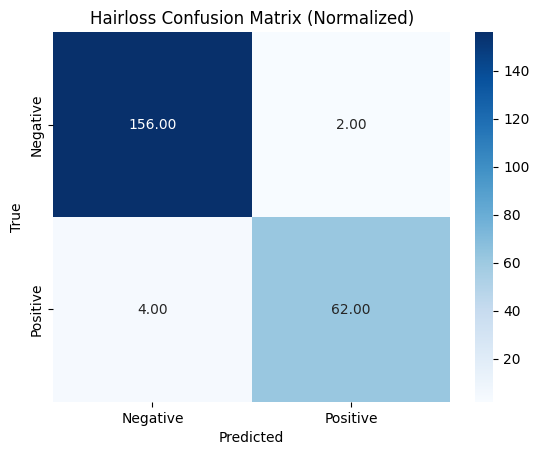

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_target, pred)

labels = ['Negative', 'Positive']  # 이진 분류 레이블
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
# title 에서 앞부분 본인 주제에 맞는 걸로 바꿔주세요.
plt.title('Hairloss Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()